## Neural network playing ground (Small Methods Imgs)
### Nov 2023 - Code by Mauricio Cano Galván

Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

from nn_backend.import_xyz_img import import_xyz_img
from nn_backend.conv_imgs import conv_imgs
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import cm, colormaps
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.optimizers import Adam
from keras.utils import set_random_seed
from scipy.stats import norm
import seaborn as sns
import math
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from nn_backend.modified_loss_functions import cube_msle, linear_msle
from skimage import morphology
from nn_backend.data_import import import_curves_from_folder, curve_calibration, matrix_cut, data_augment, mask_from_topo
from nn_backend.nn_for_ep import nn_for_ep
from nn_backend.post_process import prediction_reconstruction_with_train, img_export, histogram_export
from nn_backend.extras import simulation_table_import


viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:33, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

In [2]:
sim_tables_folder=rf'c:\Users\mcano\Code\rawdata\img_data\FHRbact1\Out_GetEpOnpx_2024-4_from_OUT_qi_sh4_tip2-data-2023.11.10-16.34.43.387_21-Mar-2024-19-13-48\tablas'
curves_max_limit=250
yess=simulation_table_import(sim_tables_folder, curves_max_limit)

In [2]:
#Constant Setup
pctg=90


cutout_size=33

#Graphics (1 to show images, 0 to not)
kernel_visualization=0 
input_imgs_view=1
train_curve=0

#NN Setup
kernel_dim=3
iterations=300
batch_sz=200

#Other parameters
#topo_area_dim=9
use_last_curves=1

name='efm9'
curves_file=rf'c:\Users\mcano\Code\rawdata\preprocessed curves\efm9_curves_calibrated.npy'
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\FHRbact1\Out_GetEpOnpx_2024-4_from_OUT_qi_sh4_tip2-data-2023.11.10-16.34.43.387_21-Mar-2024-19-13-48\FlattenTopo_.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\FHRbact1\Out_GetEpOnpx_2024-4_from_OUT_qi_sh4_tip2-data-2023.11.10-16.34.43.387_21-Mar-2024-19-13-48\Map_Ep.txt"
raw_curves_folder=0
curves_max_limit=1000
calibrate_curves=1
nu_dim=224
og_dim=256
ref_flip=0
topo_flip=1

Data Import

In [3]:
#Curve import
if not raw_curves_folder:
    curves_projected=pd.DataFrame(np.load(rf'{curves_file}'))
    curves_projected=curves_projected.interpolate(axis=1)
    curves_projected=curves_projected.bfill(axis=1)
else:
    curves_projected, m_vec=import_curves_from_folder(curves_file)

    if calibrate_curves:
        K=0.718
        G=200
        uac=3
        curves_projected=curve_calibration(curves_projected, m_vec, K, G, uac)



In [4]:
#curves_name=rf'efm9_curves_calibrated'
#np.save('{curves_name}.npy', curves_projected)

In [5]:
use_lift_files=1
if use_lift_files:
    lifts=[20,30,40,80,150]
    samples=lifts
    lift_samples=[]
    for l in lifts:
        file, ax_ep, ay_ep= import_xyz_img(rf'c:\Users\mcano\Code\rawdata\img_data\FHRbact1\Out_GetEpOnpx_2024-4_from_OUT_qi_sh4_tip2-data-2023.11.10-16.34.43.387_21-Mar-2024-19-13-48\lifts\LiftPower_{l}_.txt')
        lift_samples.append(file)
    lift_samples=np.array(lift_samples).reshape(og_dim,og_dim,len(lifts))

(-0.5, 223.5, 223.5, -0.5)

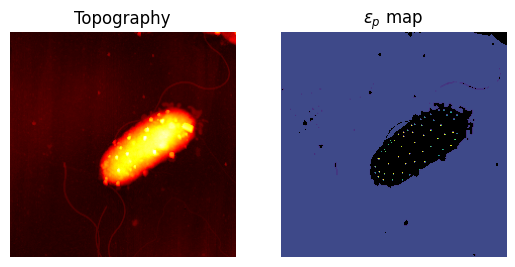

In [6]:
#------Import the label data (εp map), as a matrix first and then transformed into a DataFrame.------#
#----------The data is then cleaned to remove outliers
y_mat, ax_ep, ay_ep= import_xyz_img(ref_file)
if ref_flip:
    y_mat=np.flipud(y_mat)
y_mat=matrix_cut(y_mat,nu_dim)
y=pd.DataFrame(np.reshape(y_mat,nu_dim**2))

if use_lift_files:
    curves_sampled=matrix_cut(lift_samples, nu_dim)
else:
#Logarithmic sampling
    maxlen=1713
    curve_height_setpoint=20
    curve_nsamples=12

    zs=np.round((np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint)).astype(int)
    samples = []
    [samples.append(x) for x in zs if x not in samples]


    #New curves
    curves=(np.array(curves_projected)).reshape(og_dim,og_dim,len(curves_projected.iloc[0,:]))
    curves=matrix_cut(curves, nu_dim)
    curves_sampled=curves[:,:,samples]

#Topography import
T_mat, x, y2 = import_xyz_img(topography_file)
T_mat=matrix_cut(T_mat, nu_dim)
T_mat=np.expand_dims(T_mat, axis=2)
T=T_mat.reshape(nu_dim**2)
#Put together training dataset
X_mat=np.concatenate((T_mat, curves_sampled), axis=2)

aa=["Z = "+str(x)+" nm" for x in samples]
inputs=["Topography"]
inputs=np.append(inputs, aa)

X=np.reshape(X_mat,(nu_dim**2,len(X_mat[0,0,:])))
X=pd.DataFrame(X, columns=inputs)


plt.subplot(1,2,1)
plt.imshow(T_mat, cmap='hot')
plt.title('Topography')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y_mat, cmap=newcmp, vmin=-1, vmax=8)
plt.title('$ε_p$ map')
plt.axis('off')

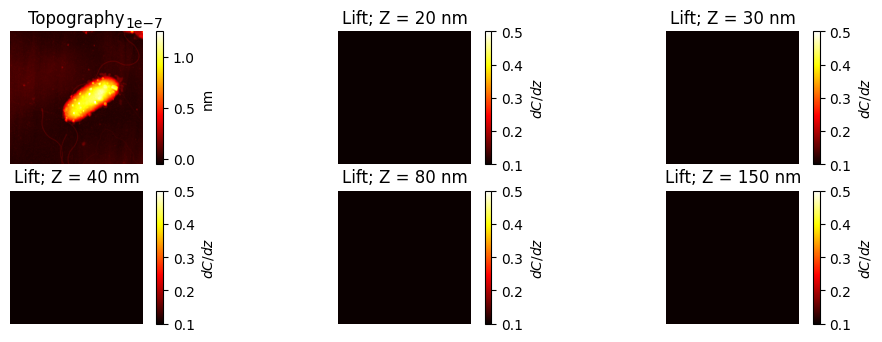

In [7]:
if input_imgs_view:
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(5,3,1)
    pcm=ax.imshow(X_mat[:,:,0], cmap='hot')
    ax.set_title("Topography")
    plt.colorbar(pcm, label="nm")
    ax.axis('off')
    for i in range(2,len(X.iloc[0])+1):
        ax=fig.add_subplot(5,3,i)
        pcm=ax.imshow(X_mat[:,:,i-1], cmap='hot', vmin=0.1, vmax=0.5)
        h=samples[i-2]
        ax.set_title("Lift; Z = "+str(h)+" nm")
        plt.colorbar(pcm, label="$dC/dz$")
        ax.axis('off')
     

Data Pre-Processing

C:\Users\mcano\AppData\Local\Temp\ipykernel_13240\315333761.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))


Text(0.5, 1.0, 'Final Train Mask')

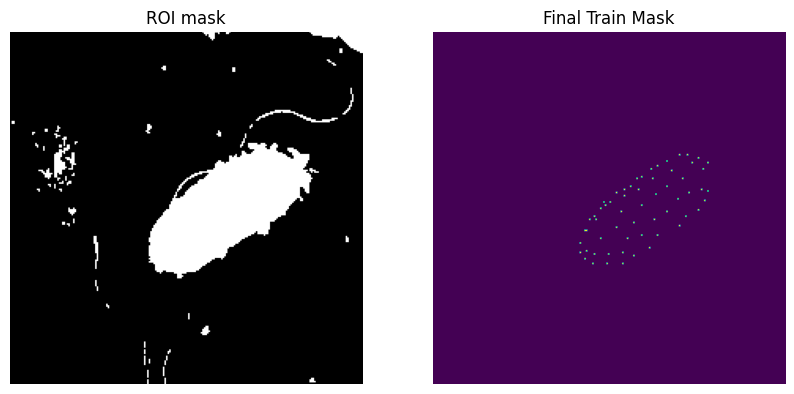

In [8]:
#EFM9: binary_threshold=0.01, object_size=3, hole_size=30, m_thresh=0.30
#EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
#EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
#EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785

binary_threshold=0.067
object_size=3
hole_size=30
m_ep_thresh=0.30

bin=mask_from_topo(T,binary_threshold,object_size,hole_size)

cell=bin.reshape(nu_dim**2,1)
roi_index=pd.DataFrame(copy(cell))
roi_index=roi_index.index[(roi_index[0])]


mask_ep=pd.DataFrame(copy(y))
th=float(mask_ep.quantile(m_ep_thresh))

mask_ep[(mask_ep[0]<=th)]=0
mask_ep[(mask_ep[0]!=0)]=1
mask_ep=cell*mask_ep
mask_ep_im=np.reshape(np.array(mask_ep), ((nu_dim),(nu_dim)))

cell_index=mask_ep.index[mask_ep[0]>0].tolist()


fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(1,2,1)
ax.imshow(bin, cmap='gray')
ax.set_title('ROI mask')
ax.axis('off')
ax=fig.add_subplot(1,2,2)
ax.imshow(mask_ep_im)
ax.axis('off')
ax.set_title('Final Train Mask')


In [9]:
#------Cell separation------#
y_cell=pd.DataFrame(y.iloc[cell_index])
X_cell=pd.DataFrame(X.iloc[cell_index])
y_roi=pd.DataFrame(y.iloc[roi_index])
X_roi=pd.DataFrame(X.iloc[roi_index])


#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)
Xn_roi=pd.DataFrame(curve_scale.transform(X_roi), columns=inputs)

In [10]:

#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)

In [11]:

topo_mat, x, y2 = import_xyz_img(topography_file)
topo=topo_mat.reshape(len(topo_mat)**2,1)

topo_scale=StandardScaler()
topo_scale.fit(topo)
topo_n=topo_scale.transform(topo)
topo_n_mat=topo_n.reshape(len(topo_mat),len(topo_mat),1)


In [13]:
full_cutouts=0

if full_cutouts:
    Cv_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size)
    Cv_mat=Cv_mat.reshape(int(math.sqrt(len(Cv_mat))),int(math.sqrt(len(Cv_mat))),cutout_size,cutout_size)
    Cv_mat=matrix_cut(Cv_mat, nu_dim)

    Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
    Cv_mat=np.expand_dims(Cv_mat, axis=-1)

    Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
    Cv_mat=np.expand_dims(Cv_mat, axis=-1)
    Cv_cell_mat=Cv_mat[cell_index,:,:,:]
    Cv_roi_mat=Cv_mat[roi_index,:,:,:]
else:
    y_coord, x_coord= np.unravel_index(cell_index, (nu_dim, nu_dim))
    cell_index_2=np.transpose(np.column_stack((y_coord, x_coord)))
    cell_index_2[0]=cell_index_2[0]+int((cutout_size-1)/2)
    cell_index_2[1]=cell_index_2[1]+int((cutout_size-1)/2)

    y_coord, x_coord= np.unravel_index(roi_index, (nu_dim, nu_dim))
    roi_index_2=np.transpose(np.column_stack((y_coord, x_coord)))
    roi_index_2[0]=roi_index_2[0]+int((cutout_size-1)/2)
    roi_index_2[1]=roi_index_2[1]+int((cutout_size-1)/2)

    Cv_cell_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size, cell_index_2)
    Cv_roi_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size, roi_index_2)
    Cv_cell_mat=np.expand_dims(Cv_cell_mat, axis=-1)
    Cv_roi_mat=np.expand_dims(Cv_roi_mat, axis=-1)
    



100%|██████████| 5675/5675 [00:48<00:00, 116.05it/s]


Test-Train Separation

In [14]:

sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(Xn_cell, y_cell)
train_index, test_index = next(sss.split(Xn_cell, y_cell))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = Xn_cell.iloc[train_index], Xn_cell.iloc[test_index] 
y_train, y_test = y_cell.iloc[train_index], y_cell.iloc[test_index]

Cv_train, Cv_test = Cv_cell_mat[train_index,:,:], Cv_cell_mat[test_index,:,:] 
Cv_train_aug=data_augment(Cv_train)


N_aug=int(len(Cv_train_aug[:,0,0,0])/len(Cv_train[:,0,0,0]))

X_train_aug=copy(X_train)
y_train_aug=copy(y_train)
for i in np.arange(N_aug-1):
    X_train_aug=pd.DataFrame(np.concatenate((X_train_aug, X_train), axis=0))
    y_train_aug=pd.DataFrame(np.concatenate((y_train_aug, y_train), axis=0))

Network Architecture

In [15]:
#------Example Keras Network------#
reg, histo=nn_for_ep(X_train_aug,Cv_train_aug,y_train_aug,X_test,Cv_test,y_test, verb=0)

Results

In [16]:
res=reg.predict([Xn_roi, Cv_roi_mat])

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Results visualization

0.9054


C:\Users\mcano\AppData\Local\Temp\ipykernel_13240\2879703696.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_roi[roi_index[i]]=res[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_13240\2879703696.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  full_vec_roi[i]=y.iloc[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_13240\2879703696.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_cell[cell_index[i]]=res_cell[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_13240\2879703696.py:23: RuntimeWarning: divide by zero encount

The error map presents 6 error values > 1 (10.0%)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Resultado de red neuronal (train data=90%)')

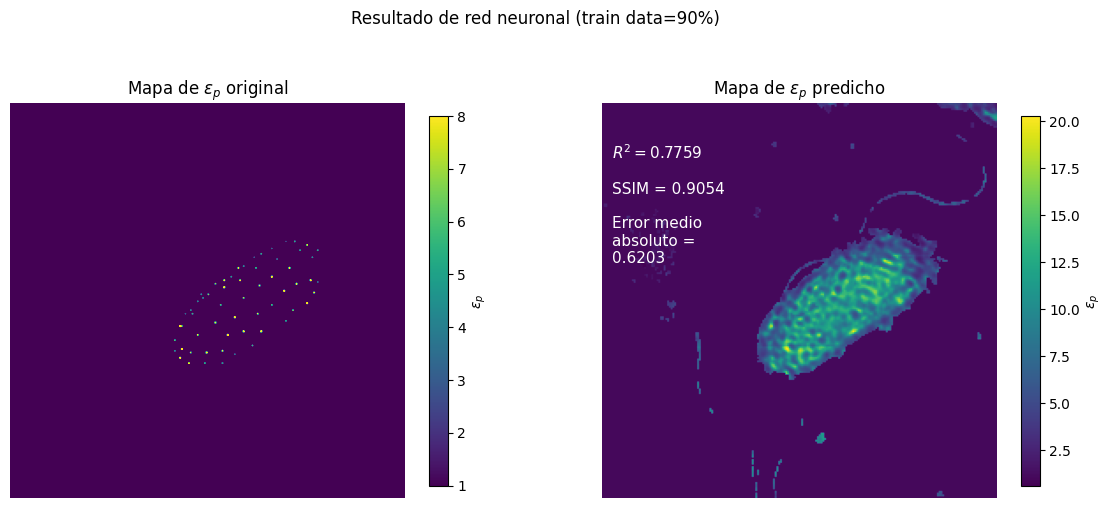

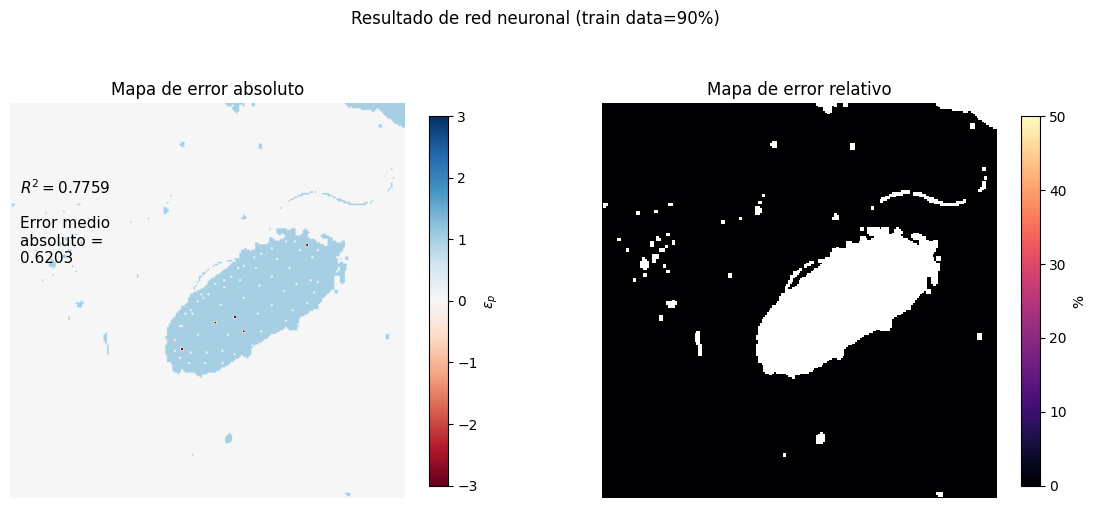

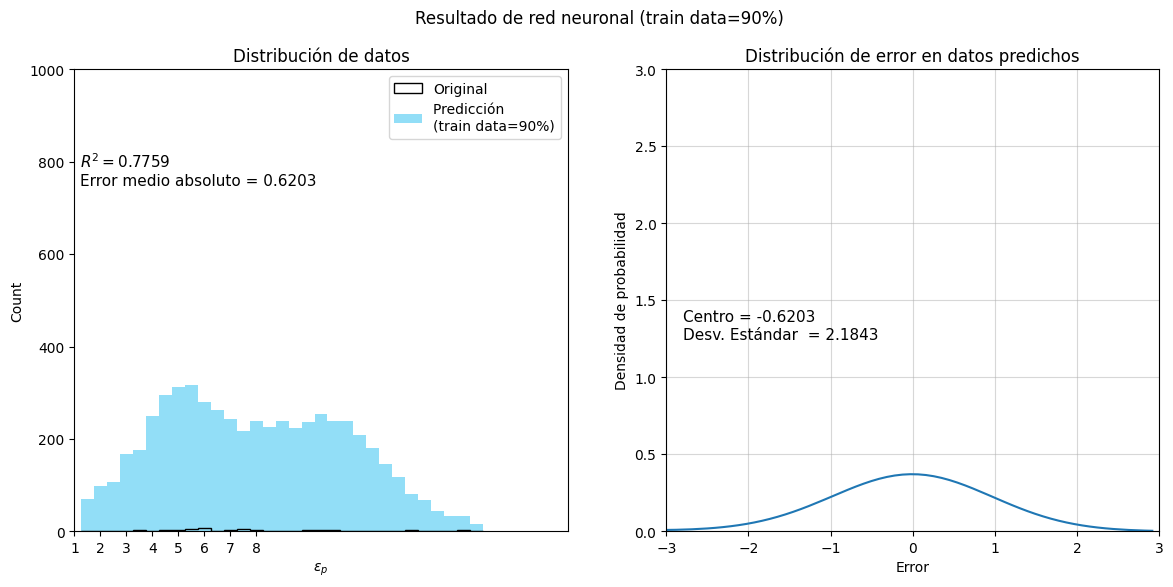

<Figure size 640x480 with 0 Axes>

In [17]:
full_vec_roi=np.zeros(nu_dim**2)+1
for i in np.arange(len(roi_index)):
    full_vec_roi[roi_index[i]]=res[i]



for i in y.index[np.array(cell_index)[train_index]]:
    full_vec_roi[i]=y.iloc[i]

full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))
full_vec_roi=pd.DataFrame(full_vec_roi)
full_roi=copy(full_vec_roi)
full_cell=pd.DataFrame(full_roi.iloc[roi_index])

#Metrics calculations
res_cell=np.array(full_vec_roi.iloc[cell_index])
full_vec_cell=np.zeros(nu_dim**2)+1
for i in np.arange(len(cell_index)):
    full_vec_cell[cell_index[i]]=res_cell[i]
full_img_cell=np.reshape(full_vec_cell,(nu_dim,nu_dim))

error_map=np.subtract(full_img_cell,y_mat)
error_map_r=(abs(np.subtract(y_mat, full_img_cell))/y_mat)*100

from skimage.metrics import structural_similarity as ssim

ssim = np.round(ssim(y_mat, full_img_cell, data_range=full_img_cell.max() - full_img_cell.min()), decimals=4)
print(ssim)

rsqr_cell=np.round(r2_score(y_cell, res_cell), decimals=4)
mae_cell=mean_absolute_error(y_cell, res_cell)


fig1=plt.figure(figsize=(14,6))

ax=fig1.add_subplot(1,2,1)
pcm=ax.imshow(y_mat, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ original")


ax=fig1.add_subplot(1,2,2)
pcm=ax.imshow(full_img_roi)#, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ predicho")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nSSIM = "+str(ssim)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#fff")

fig1.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig2=plt.figure(figsize=(14,6))

ax=fig2.add_subplot(1,2,1)
pcm=ax.imshow(error_map, cmap="RdBu", vmin=-3, vmax=3)
ax.set_title("Mapa de error absoluto")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_p$")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")

ax=fig2.add_subplot(1,2,2)
pcm=ax.imshow(error_map_r, cmap="magma", vmin=0, vmax=50)
ax.set_title("Mapa de error relativo")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="%")


fig2.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig3=plt.figure(figsize=(14,6))

ax=fig3.add_subplot(1,2,1)
binss=(np.arange(32)*0.50)+1.25
xaxis=(np.arange(9))
ax.hist(y_cell, histtype="step", color="#000",bins=binss)
ax.hist(full_cell, histtype="bar", color="#92def7",bins=binss)
ax.set_xticks(xaxis)
ax.set_xlim([1,20])
ax.set_ylim([0,1000])
ax.set_title("Distribución de datos")
ax.legend(["Original","Predicción \n(train data="+str(pctg)+"%)"])
ax.set_xlabel("$ε_{p}$")
ax.set_ylabel("Count")
ax.text(1.2, 750, "$R^2 = $"+str(rsqr_cell)+"\nError medio absoluto = "+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")



thresh=1
print("The error map presents "+str(len(error_map[abs(error_map)>thresh]))+" error values > "+str(thresh)+" ("+str(np.round((len(error_map[abs(error_map)>thresh])/len(y_cell))*100, decimals=2))+"%)")
plt.figure()
err=pd.DataFrame(np.subtract(res_cell,y_cell))
ax=fig3.add_subplot(1,2,2)
ax = sns.kdeplot(data=err, ax=ax)
legend=ax.legend()
legend.remove()
ax.set_title("Distribución de error en datos predichos")
ax.set_xlabel("Error")
ax.set_ylabel("Densidad de probabilidad")
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.grid('on', alpha=0.5)
err_mean, err_std=norm.fit(err)
ax.text(-2.8, 1.25, "Centro = "+str(np.round(err_mean, decimals=4))+"\nDesv. Estándar  = "+str(np.round(err_std, decimals=4)), fontsize=11, color="#000")

fig3.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")


Text(0.5, 1.0, 'Mapa de $ε_p$ original')

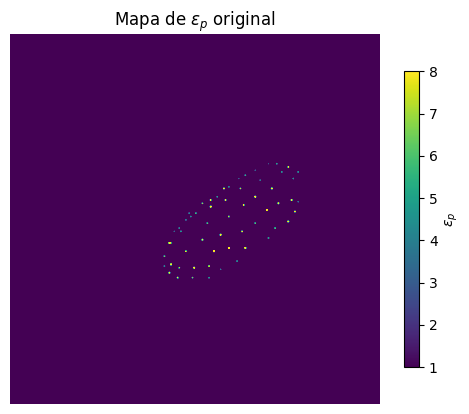

In [18]:
ff=plt.figure()
ax=ff.add_subplot(1,1,1)
pcm=ax.imshow(y_mat, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ original")

In [19]:
export=0

filename=rf'{name}_linear'
folder=rf'd:\Exports\pres240510'



if export:
    img_export(filename, folder, full_img_roi, full_cell, topography_file, nu_dim)
    histogram_export(full_cell, filename, folder)


export_ref=0

filename=rf'{name}_sim'
folder=rf'd:\Exports\pres240510'

if export_ref: 
    img_export(filename, folder, y_mat, y_cell, topography_file, nu_dim)
    histogram_export(y_cell, filename, folder)
